# Логистическая регрессия без регуляризации
Метод: градиентный спуск

Оптимизируемая величина: логарифмическая функция потерь

In [1]:
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

### Создание набора данных:

In [2]:
X, Y= make_classification(n_samples=500, n_features=2, n_classes=2, weights=[0.7, 0.3], random_state=7, n_informative=2, n_redundant=0)

### Разделение выборки на обучающую и тестовую. Соотношение: 70 / 30

In [3]:
koef = 0.7 # Коэффициент разделение обучающей и тестовой выборок

shuffle_index = np.random.permutation(X.shape[0])

X_shuffled = X[shuffle_index]
Y_shuffled = Y[shuffle_index]

X_train = X_shuffled[:int(X.shape[0] * koef)]
X_test = X_shuffled[int(X.shape[0] * koef):]

Y_train = Y_shuffled[:int(X.shape[0] * koef)]
Y_test = Y_shuffled[int(X.shape[0] * koef):]

### Визуализация тестовой выборки:

In [4]:
# Макрос разделения данных на классы по значению Y = target_Y
def devide_by_class(X, Y, target_Y):
    X = pd.DataFrame(X)
    Y = pd.DataFrame(Y)
    return pd.DataFrame(X[Y[0] == target_Y])

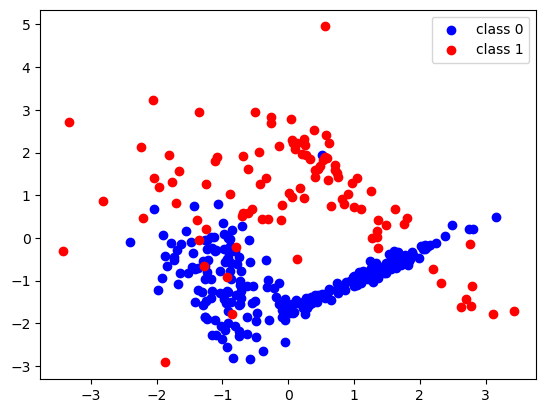

In [5]:
X_class_0 = devide_by_class(X_train, Y_train, 0)
X_class_1 = devide_by_class(X_train, Y_train, 1)

plt.scatter(X_class_0[0], X_class_0[1], color='b', label = 'class 0')
plt.scatter(X_class_1[0], X_class_1[1], color='r', label = 'class 1')
plt.legend()
plt.show()

### Макрос, вычисляющий сигмоиду:
$$\sigma(z) = \frac{1}{1 + exp(-z)}.$$

In [6]:
# Функция вычисления сигмоиды
def sigmoid(x):
    result = 1/(1 + np.exp(-x))
    return result

### Макрос, вычисляющий логарифмическую функцию потерь:
$$-\text{ln}L(X) = -\frac{1}{l}\sum^{l}_{i=1} (y_{i} \text{ln}(\sigma) + (1 - y_{i})\text{ln} (1-\sigma)).$$

In [7]:
# Логарифмисеская функция потерь:
def log_loss(X, Y, W):
    sigmas = sigmoid(np.dot(X, W))   
    
    log = 0
    
    for i in range(Y.shape[0]):
                                        # Натуральный логарифм нуля равен бесконечности. Для обхода этого значения
        if sigmas[i] == 1:              # заменим значение сигмы, равное 1 или 0, на очень близкие к ним
            sigmas[i] = 1 - 1e-9
        elif sigmas[i] == 0:
            sigmas[i] = 1e-9
        
        log += Y[i] * np.log(sigmas[i])
        log += (1-Y[i]) * np.log(1 - sigmas[i])
        
    log = -1 / Y.shape[0] * log
    
    return log

### Макрос, вычисляющий градиент функции потерь:
$$grad = \frac{1}{l}(A-Y)^{T}X,$$

$$A=\frac{1}{1 + exp(-\left \langle x_{i},w \right \rangle)}.$$

In [8]:
# Градиент логарифмической функции потерь
def grad_log_los(X, Y, W):
    A = sigmoid(np.dot(X, W))
    return 1 / Y.shape[0] * np.dot((A-Y).T, X)

### Функция вычисления уточненных значений весов (через вычет градиента):
$$w_{n+1} = w_{n} - \eta*grad$$
### Функция оптимизации:

In [9]:
# Функция оптимизации. Размер шага спуска по градиенту в процессе выполнения макроса изменяется автоматически (reduce_eta_step=True)
# Если stop_after_5_repeated_errors=True, макрос завершит работу, если 5 последних ошибок одинаковы.

def optimization(X_train, Y_train, eta=100, max_steps=1000, min_loglos_error = 0.00001, reduce_eta_step=True, stop_after_5_repeated_errors=True):
    
    # Массив - лог ошибок логарифмической функции потерь
    log_loglos = [np.inf]
    
    # Текущая итерация
    current_step = 0
    
    # Ошибка логарифмической функции потерь на текущей итерации
    current_error = np.inf
    
    # Инициализация начальных значений весов
    w = np.zeros([X.shape[1]])
    
    while current_step < max_steps and current_error > min_loglos_error:
        current_step +=1
        current_error = log_loss(X, Y, w)
        
        # Изменение шага спуска по градиенту, если логарифмическая функция потерь начинает увеличиваться
        if reduce_eta_step:
            if current_error >= log_loglos[-1]:
                eta = eta / 10
        
        log_loglos.append(current_error)
        grad = grad_log_los(X,Y,w)
        w += - eta*grad
        
        # Остановка макроса, если 5 последних значений логарифмической функции потерь равны между собой
        if stop_after_5_repeated_errors and current_step >=5:
            if log_loglos[-1] == log_loglos[-2] == log_loglos[-3] == log_loglos[-4] == log_loglos[-5]:
                print(f'Finish after 5 identical errors. Current step: {current_step}')
                break
    
    # Возвращает последние веса, а также лог изменения логарифмической функции потерь
    return w, log_loglos[1:]

Finish after 5 identical errors. Current step: 123
Финальная ошибка составляет 0.332


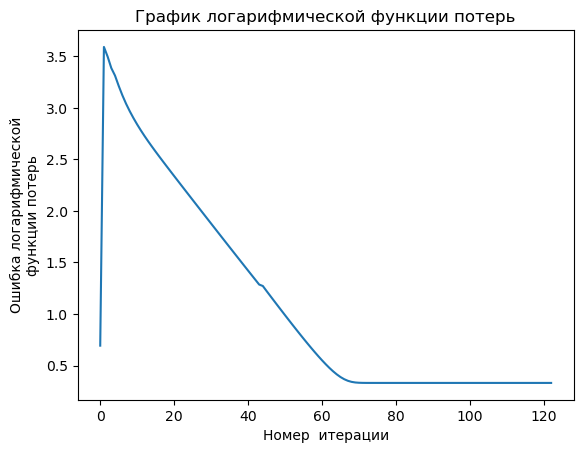

In [10]:
# Изначальный "изгиб" на графике объясняется автоматическим уменьшением шага спуска по градиенту
w, log_loglos = optimization(X, Y, max_steps=1000, eta=100)
print(f'Финальная ошибка составляет {round(log_loglos[-1], 3)}')
plt.plot(log_loglos)
plt.title('График логарифмической функции потерь')
plt.xlabel('Номер  итерации')
plt.ylabel('Ошибка логарифмической\nфункции потерь')
plt.show()

### Функция классификации (предсказывания) на основе сигмоиды:

In [11]:
#  Макрос выполнения предсказаний. Возвращает предсказанный класс, а также вероятность того, что объект принадлежит 1му классу.
def predict(X, w):
    
    # Вероятность быть 1м классом
    sigmas = sigmoid(np.dot(X, w))
    
    # Массив значений класса для каждого объекта
    values = np.zeros(X.shape[0])
    
    for i in range(len(sigmas)):
        if sigmas[i] >= 0.5:
            values[i] =1
    
    return values, sigmas

In [12]:
y_pred_train, chance_to_be_first_class_train = predict(X_train, w)
y_pred_test, chance_to_be_first_class_test = predict(X_test, w)

### Функции вычисления метрик:

In [13]:
# Функция вычисления accuracy
def accuracy(y_true, y_pred):
    
    # Корректные ответы:
    correct_answers = 0
    
    for i in range(y_true.shape[0]):
        if y_true[i]==y_pred[i]:
            correct_answers += 1
    return correct_answers / y_true.shape[0]

In [14]:
# Функция вычисления точности логистической регрессии
def precision(y_true, y_pred, target_class=1):
    
    # Правильные ответы:
    correct_answers = 0
    
    # Все ответы для данного класса:
    total_answers_for_target_class = 0
    
    for i in range(y_true.shape[0]):
        if y_pred[i] == target_class:
            total_answers_for_target_class += 1
            if y_true[i] == target_class:
                correct_answers += 1
    
    # Защита от дурака:
    if total_answers_for_target_class == 0:
        return np.inf
    else:
        return correct_answers / total_answers_for_target_class      

In [15]:
# Функция вычисления полноты логистической регрессии
def recall(y_true, y_pred, target_class=1):
    
     # Правильные ответы:
    correct_answers = 0
    
    # Все ответы для данного класса:
    total_answers_for_target_class = 0
    
    for i in range(y_true.shape[0]):
        if y_true[i] == target_class:
            total_answers_for_target_class += 1
            if y_pred[i] == target_class:
                correct_answers += 1
    
    # Защита от дурака:
    if total_answers_for_target_class == 0:
        return np.inf
    else:
        return correct_answers / total_answers_for_target_class   

In [16]:
# Функция вычисления F - меры
def f_score(y_true, y_pred, target_class, betta = 1):
    recall_target_class = recall(y_true, y_pred, target_class=target_class)
    precision_target_class = precision(y_true, y_pred, target_class=target_class)
    
    # Защита от дурака:
    if betta**2 * precision_target_class + recall_target_class == 0:
        return np.inf
    else:
        return (1 + betta**2) * precision_target_class * recall_target_class / (betta**2 * precision_target_class + recall_target_class)

In [17]:
accuracy_train = round(accuracy(Y_train, y_pred_train), 3)
precision_train_first = round(precision(Y_train, y_pred_train, 1), 3)
recall_train_first = round(recall(Y_train, y_pred_train, 1), 3)
f_score_train_first = round(f_score(Y_train, y_pred_train, 1, betta = 0), 3)

precision_train_zero = round(precision(Y_train, y_pred_train, 0), 3)
recall_train_zero = round(recall(Y_train, y_pred_train, 0), 3)
f_score_train_zero = round(f_score(Y_train, y_pred_train, 0, betta = 0), 3)

In [18]:
accuracy_test = round(accuracy(Y_test, y_pred_test), 3)
precision_test_first = round(precision(Y_test, y_pred_test, 1), 3)
recall_test_first = round(recall(Y_test, y_pred_test, 1), 3)
f_score_test_first = round(f_score(Y_test, y_pred_test, 1, betta = 0), 3)

precision_test_zero = round(precision(Y_test, y_pred_test, 0), 3)
recall_test_zero = round(recall(Y_test, y_pred_test, 0), 3)
f_score_test_zero = round(f_score(Y_test, y_pred_test, 0, betta = 0), 3)

### Выводы:

In [19]:
print(f'На обучающей выборке для первого класса:\naccuracy = {accuracy_train}\nprecision = {precision_train_first}\nrecall = {recall_train_first}\nf_score(betta=1) = {f_score_train_first}')

На обучающей выборке для первого класса:
accuracy = 0.903
precision = 0.83
recall = 0.83
f_score(betta=1) = 0.83


In [20]:
print(f'На обучающей выборке для нулевого класса:\naccuracy = {accuracy_train}\nprecision = {precision_train_zero}\nrecall = {recall_train_zero}\nf_score(betta=1) = {f_score_train_zero}')

На обучающей выборке для нулевого класса:
accuracy = 0.903
precision = 0.932
recall = 0.932
f_score(betta=1) = 0.932


In [21]:
print(f'На тестовой выборке для первого класса:\naccuracy = {accuracy_test}\nprecision = {precision_test_first}\nrecall = {recall_test_first}\nf_score(betta=1) = {f_score_test_first}')

На тестовой выборке для первого класса:
accuracy = 0.873
precision = 0.905
recall = 0.717
f_score(betta=1) = 0.905


In [22]:
print(f'На тестовой выборке для нулевого класса:\naccuracy = {accuracy_test}\nprecision = {precision_test_zero}\nrecall = {recall_test_zero}\nf_score(betta=1) = {f_score_test_zero}')

На тестовой выборке для нулевого класса:
accuracy = 0.873
precision = 0.861
recall = 0.959
f_score(betta=1) = 0.861


In [23]:
print(f'Итоговые веса равны: {w}')

Итоговые веса равны: [0.20534676 2.29042598]


### Все метрики > 0.7, следовательно, классификация прошла успешно. В целях улучшения результата можно попробовать воспользоваться L2 регуляризацией.